<a href="https://colab.research.google.com/github/enidroman/Data-620-Web-Analysis/blob/main/Project1_Bikeshare_Network_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Project 1 - Chicago, IL, Bikeshare Network Analysis  
Authors: Jose Rodriguez, Enid Roman

The bike-sharing project analyzes the city's like-sharing program using network analysis. It uses data on rides, stations, and user profiles to optimize transportation efficiency and study user behaviors. By applying graph theory and clustering algorithms, the project aims to provide insights for urban planners, contributing to more efficient and eco-friendly commuting options.

Analysis Questions:

•	What is the overall topology of the bike-sharing network, and how are stations interconnected?

•	What patterns exist in user behavior, and how do they vary between member and casual users?

•	How do ride patterns differ between am and pm?

•	What are the most common starting and ending points for different user groups?


The dataset was gotten from Kaggle.comThe dataset contains data from the company that operates bike sharing services in Chicago city. The data contains 13 different datasets for each month for the year 2021. Each dataset contains 13 columns 49623 to 822411 rows each. Following are the columns in the dataset and what they represent:


1.  Types of Data (Graph, Node, Edge Attributes)

Attributes

* ride_id : the unique id to refer to each trip

* rideable_type : the type of the bike used for the trip

* started_at : date-time for when the trip started

* ended_at : date-time for when the trip ended

* start_station_name : name of the station from where the trip started

* start_station_id : unique id of the station from where the trip started

* end_station_name : name of the station where the trip ended

* end_station_id : unique id of the station where the trip ended

* start_lat : latitude of the start station

* start_lng : longitude of the start station

* end_lat : latitude of the end station

* end_lng : longitude of the end station

* member_casual : member denotes the users who have subscribed to annual membership, and casual denotes the users who haven't


In [1]:
#Load libraries
import pandas as pd
import networkx as nx
from matplotlib.pyplot import figure
import matplotlib.pyplot as plt
from prettytable import PrettyTable
#!pip install python-louvain matplotlib
from community import community_louvain
from itertools import combinations
import folium

## Loading the Dataset  
  
The Bikeshare dataset was found to be too large to load into a GitHub repository. As a result, AWS S3 service was used as an alternative storage solution. In simple terms, the csv file was loaded into a bucket and given public read access. This allows the dataset to be read directly into a notebook with via a URL.

In [2]:
#Loading csv file into notebook
url = 'https://data620bucket.s3.us-east-2.amazonaws.com/202107-divvy-tripdata.csv'
df = pd.read_csv(url)

In [3]:
#Calculate Ride Duration
# Ensure the columns are in datetime format
df['started_at'] = pd.to_datetime(df['started_at'])
df['ended_at'] = pd.to_datetime(df['ended_at'])
df['ride_duration_minutes'] = (df['ended_at'] - df['started_at']).dt.total_seconds() / 60
df = df.query('ride_duration_minutes >= 2')

In [4]:
df.head(5)

,ride_id,rideable_type,started_at,ended_at,start_station_name,start_station_id,end_station_name,end_station_id,start_lat,start_lng,end_lat,end_lng,member_casual,ride_duration_minutes
0,0A1B623926EF4E16,docked_bike,2021-07-02 14:44:36,2021-07-02 15:19:58,Michigan Ave & Washington St,13001,Halsted St & North Branch St,KA1504000117,41.883984,-87.624684,41.899368,-87.648480,casual,35.366667
1,B2D5583A5A5E76EE,classic_bike,2021-07-07 16:57:42,2021-07-07 17:16:09,California Ave & Cortez St,17660,Wood St & Hubbard St,13432,41.900363,-87.696704,41.889899,-87.671473,casual,18.450000
2,6F264597DDBF427A,classic_bike,2021-07-25 11:30:55,2021-07-25 11:48:45,Wabash Ave & 16th St,SL-012,Rush St & Hubbard St,KA1503000044,41.860384,-87.625813,41.890173,-87.626185,member,17.833333
3,379B58EAB20E8AA5,classic_bike,2021-07-08 22:08:30,2021-07-08 22:23:32,California Ave & Cortez St,17660,Carpenter St & Huron St,13196,41.900363,-87.696704,41.894556,-87.653449,member,15.033333
4,6615C1E4EB08E8FB,electric_bike,2021-07-28 16:08:06,2021-07-28 16:27:09,California Ave & Cortez St,17660,Elizabeth (May) St & Fulton St,13197,41.900350,-87.696682,41.886593,-87.658387,casual,19.050000


## Converting the Dataframe Into a Networkx Graph Object
  
For this particular dataset two different graphing approches can be taken. The first one is to use a MultiDiGraph object, which would allow all the individual edges (bike rides) to remain in the graph.
  
The second approach is to use a DiGraph object, which would only add two directional edges between nodes. However, each directional edge will have aggregate data in its attributes to avoid the loss of valuable network information. For example, an edge between station 'X' and station 'Y' can have 400 rides - this means the edge would have a ride_count attribute equal to 400. Other metrics such as average ride duration in minutes can be calculated and included.

Due to the limitations in computation capabalities and the large size of the dataset, we will opt for the DiGraph option.

### Creating Graph Object - Adding Nodes & Edges
The nodes represent unique bike stations, whereas the edges represent a trip between bike stations. It should be noted that some trips depart and arrive at the same station implying that there are self-loops in the network.

In [5]:
# Initialize an empty DiGraph
G = nx.DiGraph() #nx.MultiDiGraph()

# Add nodes with metadata from 'start_station_id' and 'start_station_name'
for _, row in df.iterrows():
    G.add_node(row['start_station_id'], name=row['start_station_name'])
    G.add_node(row['end_station_id'], name=row['end_station_name'])

print(len(G.nodes()))

712


### Adding Additonal Attributes to Nodes  

The station coordinates were added to each node. This will help with marking each station on a geographical map. In additiona, the count of self-loops have been added to each station.

In [6]:
# Group by 'Category' and get the first entry of each group
#gather start station info
station_coord_df1 = df.groupby('start_station_id').first().filter(['start_station_id', 'start_lat', 'start_lng']).reset_index().rename(columns={'start_station_id': 'station',
                                                                                                                                                'start_lat': 'lat',
                                                                                                                                               'start_lng': 'lng'})
#gather end station info
station_coord_df2 = df.groupby('end_station_id').first().filter(['end_station_id', 'end_lat', 'end_lng']).reset_index().rename(columns={'end_station_id': 'station',
                                                                                                                                                'end_lat': 'lat',
                                                                                                                                               'end_lng': 'lng'})
#Combine both dfs
combined_df = pd.concat([station_coord_df1, station_coord_df2],
                        #ignore_index=True,
                       axis=0).drop_duplicates(subset='station').set_index('station')
#print(combined_df.head(2))


pos = combined_df.apply(lambda row: (row['lat'], row['lng']), axis=1).to_dict() #Convert to dict
#print(pos)
#print(str(list(pos.keys())[0]) + " : " + str(list(pos.values())[0]))
nx.set_node_attributes(G, pos, 'coord') #Set coord attribute to graph

#Get number of selfloops for each station and add as an attribute to each station
self_loop_agg_df = df.query('start_station_id == end_station_id').groupby(['start_station_id', 'end_station_id']).agg(total_rides=('ride_id', 'count')).reset_index().drop(['start_station_id'], axis=1).rename(columns={'end_station_id': 'station'}).set_index('station')
print(self_loop_agg_df.head(2))

self_loops_dict = self_loop_agg_df.apply(lambda row: (row['total_rides']), axis=1).to_dict() #Convert to dict
#print(self_loops_dict)

nx.set_node_attributes(G, self_loops_dict, 'self_loops')

         total_rides
station             
13001            238
13006             43


In [7]:
#Check attributes for a node:
for node in G.nodes(data=True):
    print(node)
    break

('13001', {'name': 'Michigan Ave & Washington St', 'coord': (41.883984, -87.624684), 'self_loops': 238})


In [8]:
#Aggregate data for edge attributes:
edge_aggregates = df.drop(df[df.start_station_id == df.end_station_id].index).groupby(['start_station_id', 'end_station_id']).agg(
    total_rides=('ride_id', 'count'),
    average_ride_duration_minutes=('ride_duration_minutes', 'mean'),
    casual=('member_casual', lambda x: (x == 'casual').sum()),
    member=('member_casual', lambda x: (x == 'member').sum()),
    classic_bike=('rideable_type', lambda x: (x == 'classic_bike').sum()),
    docked_bike=('rideable_type', lambda x: (x == 'docked_bike').sum()),
    electric_bike=('rideable_type', lambda x: (x == 'electric_bike').sum())
).reset_index()

edge_aggregates.head()


,start_station_id,end_station_id,total_rides,average_ride_duration_minutes,casual,member,classic_bike,docked_bike,electric_bike
0,13001,13006,16,81.557292,12,4,7,6,3
1,13001,13008,107,59.175857,92,15,62,35,10
2,13001,13011,15,9.850000,7,8,10,0,5
3,13001,13016,47,19.808865,38,9,23,11,13
4,13001,13017,8,27.527083,3,5,6,1,1


In [9]:
#Adding Edge Metadata to the Graph Object
for _, row in edge_aggregates.iterrows():
    G.add_edge(row['start_station_id'], row['end_station_id'],
               total_rides = row['total_rides'],
               avg_ride_duration_min = row['average_ride_duration_minutes'],
               casual = row['casual'],
               member = row['member'],
               classic_bike = row['classic_bike'],
               docked_bike = row['docked_bike'],
               electric_bike = row['electric_bike'])

In [10]:
#check attributes for an edge:
start_station_id = list(G.edges(data=True))[0][0]
end_station_id = list(G.edges(data=True))[0][1]

edge_metadata = G.get_edge_data(start_station_id, end_station_id)
print(edge_metadata)

{'total_rides': 16, 'avg_ride_duration_min': 81.55729166666666, 'casual': 12, 'member': 4, 'classic_bike': 7, 'docked_bike': 6, 'electric_bike': 3}


## Visualizing the Network


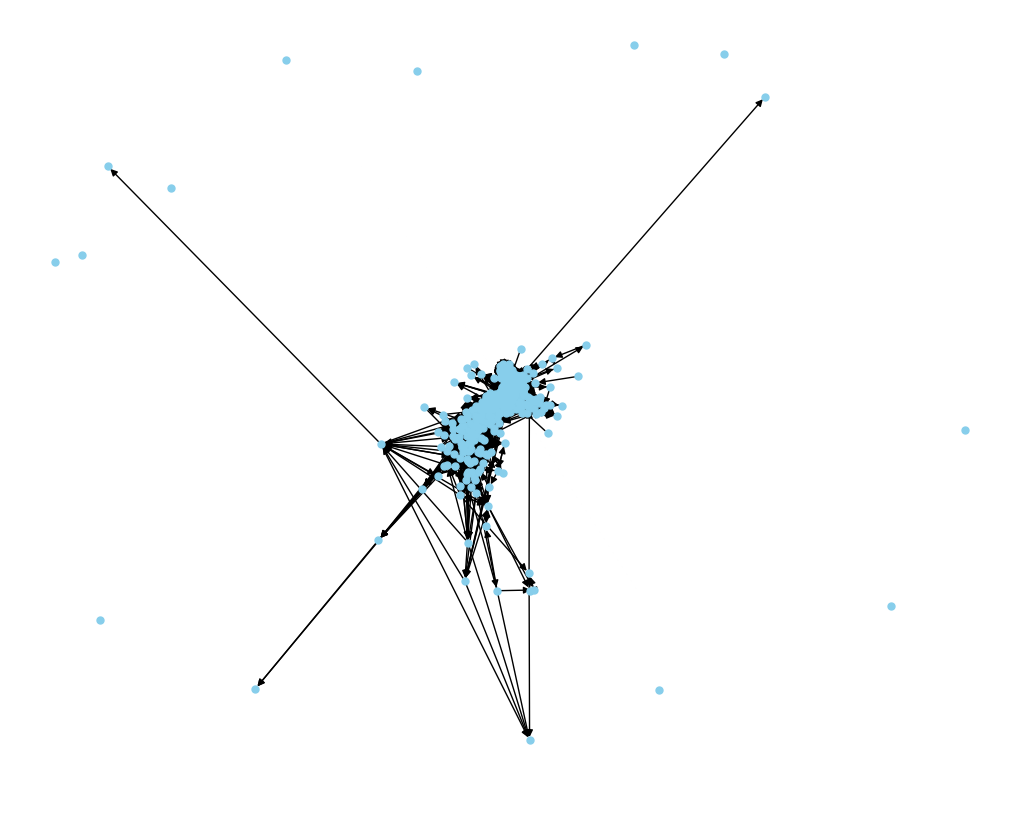

In [11]:
# # Draw the graph
figure(figsize=(10, 8))
pos = nx.spring_layout(G) # Define the layout for node positioning
nx.draw(G, pos, with_labels=False, node_size=25, node_color='skyblue', font_size=10, font_color='black')
# Display the graph
plt.show()

### Visualizing Bikesharing Network On a Geographical Map

In [12]:
#Initialize Folium Map - Does not display on google collab
# center_lat = 41.8781#G.nodes['15442']['coord'][0] #lat
# center_lon = -87.6298#G.nodes['15442']['coord'][1] #long
# m = folium.Map(location=[center_lat, center_lon], zoom_start=11)

# #Plot Nodes
# for node, data in G.nodes(data=True):
#     #print(len(data))
#     if len(data) ==1:
#         continue
#     folium.Circle(location=[data['coord'][0], data['coord'][1]],
#                   radius=100,
#                   fill_color="green",
#                   fill_opacity=0.8,
#                   popup=f'Node {node}').add_to(m)


# #Plot Edges
# for edge in list(G.edges()):
#     point1 = list(G.nodes[edge[0]]['coord']) #start
#     point2 = list(G.nodes[edge[1]]['coord']) #end
#     folium.PolyLine(locations=[point1, point2],
#                     weight=0.2,
#                     color='blue').add_to(m)

# #m.save('network_map.html')

# display(m)

## Graph Traversal Methods

Graph traversal methods involve visiting or processing nodes and edges in a graph in a specific order. Here, I'll demonstrate two common graph traversal methods: Breadth-First Search (BFS) a method for exploring the vertex level by level and Depth-First Search (DFS) a method for exploring the vertex deeply before moving to the next level. An algorithm like DFS can be used to create a tree called a DFS tree, or we can detect cycles in a graph. BFS can be used to find the shortest path in a graph.

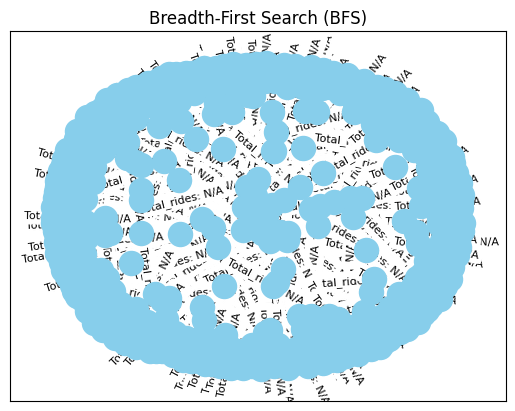

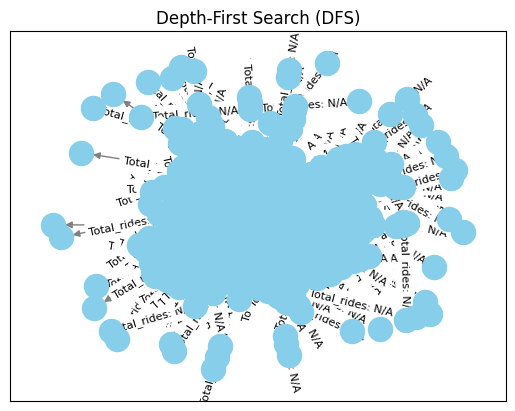

In [13]:
def visualize_graph(graph, title, edge_attr='total_rides'):
    pos = nx.spring_layout(graph)

    # Use total rides as edge labels if available
    edge_labels = {(start, end): f"{edge_attr.capitalize()}: {graph[start][end].get(edge_attr, 'N/A')}" for start, end in graph.edges}

    nx.draw_networkx_nodes(graph, pos, node_size=300, node_color='skyblue')
    #nx.draw_networkx_labels(graph, pos, font_size=8)
    nx.draw_networkx_edges(graph, pos, edge_color='gray', arrowsize=10)
    nx.draw_networkx_edge_labels(graph, pos, edge_labels=edge_labels, font_size=8)

    plt.title(title)
    plt.show()

# Breadth-First Search (BFS)
bfs_tree = nx.bfs_tree(G, source='13001')
visualize_graph(bfs_tree, title='Breadth-First Search (BFS)')

# Depth-First Search (DFS)
dfs_tree = nx.dfs_tree(G, source='13001')
visualize_graph(dfs_tree, title='Depth-First Search (DFS)')


## Network Analysis Techniques

### Centrality Measures:
Degree Centrality is a measure of the number of connections a node has in a network.

Betweenness Centrality measures the extent to which a node lies on the shortest paths between other nodes in the network.

Closeness Centrality assesses how close a node is to all other nodes in the network, emphasizing nodes that are closer to others.

Eigenvector Centrality evaluates the influence of a node in the network by considering not only its connections but also the connections of its neighbors.

This code calculates and prints the top 10 nodes by four different centrality measures in a network graph using NetworkX.

In [14]:
# Calculate Degree Centrality
degree_centrality = nx.degree_centrality(G)
sorted_degree_centrality = sorted(degree_centrality.items(), key=lambda x: x[1], reverse=True)

# Create a PrettyTable for Degree Centrality
degree_table = PrettyTable()
degree_table.field_names = ["Node", "Degree Centrality", "Top/Bottom"]

# Populate the table with the top 5 and bottom 5 nodes
for i, (node, centrality) in enumerate(sorted_degree_centrality[:5] + sorted_degree_centrality[-5:]):
    degree_table.add_row([node, centrality, "Top 5" if i < 5 else "Bottom 5"])

# Print the Degree Centrality table
print("Top 5 and Bottom 5 nodes by Degree Centrality:")
print(degree_table)

# Repeat the above steps for other centrality measures (Betweenness, Closeness, Eigenvector)

# Calculate Betweenness Centrality
betweenness_centrality = nx.betweenness_centrality(G)
sorted_betweenness_centrality = sorted(betweenness_centrality.items(), key=lambda x: x[1], reverse=True)

# Create a PrettyTable for Betweenness Centrality
betweenness_table = PrettyTable()
betweenness_table.field_names = ["Node", "Betweenness Centrality", "Top/Bottom"]

# Populate the table with the top 5 and bottom 5 nodes
for i, (node, centrality) in enumerate(sorted_betweenness_centrality[:5] + sorted_betweenness_centrality[-5:]):
    betweenness_table.add_row([node, centrality, "Top 5" if i < 5 else "Bottom 5"])

# Print the Betweenness Centrality table
print("\nTop 5 and Bottom 5 nodes by Betweenness Centrality:")
print(betweenness_table)

# Repeat similar steps for Closeness and Eigenvector centrality

# Calculate Closeness Centrality
closeness_centrality = nx.closeness_centrality(G)
sorted_closeness_centrality = sorted(closeness_centrality.items(), key=lambda x: x[1], reverse=True)

# Create a PrettyTable for Closeness Centrality
closeness_table = PrettyTable()
closeness_table.field_names = ["Node", "Closeness Centrality", "Top/Bottom"]

# Populate the table with the top 5 and bottom 5 nodes
for i, (node, centrality) in enumerate(sorted_closeness_centrality[:5] + sorted_closeness_centrality[-5:]):
    closeness_table.add_row([node, centrality, "Top 5" if i < 5 else "Bottom 5"])

# Print the Closeness Centrality table
print("\nTop 5 and Bottom 5 nodes by Closeness Centrality:")
print(closeness_table)

# Calculate Eigenvector Centrality
eigenvector_centrality = nx.eigenvector_centrality(G)
sorted_eigenvector_centrality = sorted(eigenvector_centrality.items(), key=lambda x: x[1], reverse=True)

# Create a PrettyTable for Eigenvector Centrality
eigenvector_table = PrettyTable()
eigenvector_table.field_names = ["Node", "Eigenvector Centrality", "Top/Bottom"]

# Populate the table with the top 5 and bottom 5 nodes
for i, (node, centrality) in enumerate(sorted_eigenvector_centrality[:5] + sorted_eigenvector_centrality[-5:]):
    eigenvector_table.add_row([node, centrality, "Top 5" if i < 5 else "Bottom 5"])

# Print the Eigenvector Centrality table
print("\nTop 5 and Bottom 5 nodes by Eigenvector Centrality:")
print(eigenvector_table)


Top 5 and Bottom 5 nodes by Degree Centrality:
+--------------+--------------------+------------+
|     Node     | Degree Centrality  | Top/Bottom |
+--------------+--------------------+------------+
|    13022     | 1.021097046413502  |   Top 5    |
|    LF-005    | 0.9718706047819972 |   Top 5    |
|    13042     | 0.9620253164556962 |   Top 5    |
|    13300     | 0.8860759493670887 |   Top 5    |
| TA1308000001 | 0.8776371308016878 |   Top 5    |
|    20129     |        0.0         |  Bottom 5  |
|     473      |        0.0         |  Bottom 5  |
|     354      |        0.0         |  Bottom 5  |
|    330.0     |        0.0         |  Bottom 5  |
|    20217     |        0.0         |  Bottom 5  |
+--------------+--------------------+------------+

Top 5 and Bottom 5 nodes by Betweenness Centrality:
+--------------+------------------------+------------+
|     Node     | Betweenness Centrality | Top/Bottom |
+--------------+------------------------+------------+
|    SL-005    |  0.0

The Degree Centrality is calculated as the number of edges connected to a node divided by the total number of nodes (or nodes minus one in the case of an undirected graph).
Nodes with high degree centrality are considered more central or influential in the network due to their numerous connections.

Betweenness Centrality is computed by counting the number of shortest paths between all pairs of nodes that pass through a particular node and then normalizing.
Nodes with high betweenness centrality act as bridges or mediators in the network, connecting different parts and facilitating information flow.

Closeness Centrality is calculated as the reciprocal of the sum of the shortest path distances from a node to all other nodes.
Nodes with high closeness centrality are well-connected and can quickly interact with other nodes, making them central in terms of communication and information exchange.

Eigenvector centrality is based on the eigenvector of the adjacency matrix of the network.
Nodes with high eigenvector centrality are connected to other nodes that themselves have high centrality, indicating a level of importance that goes beyond the sheer number of connections.

## Visualizing Centrality Measures

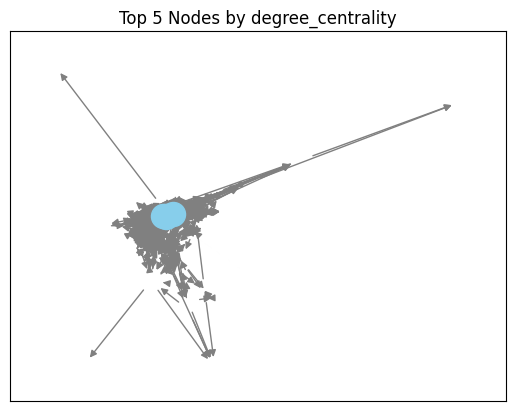

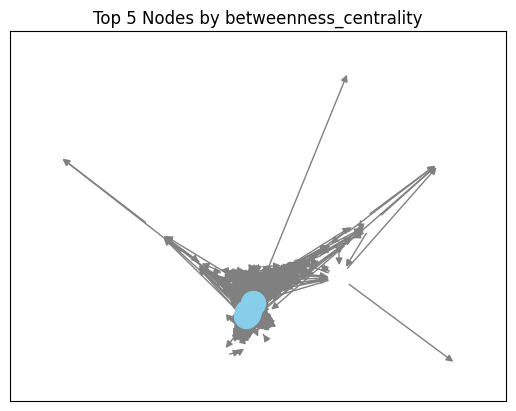

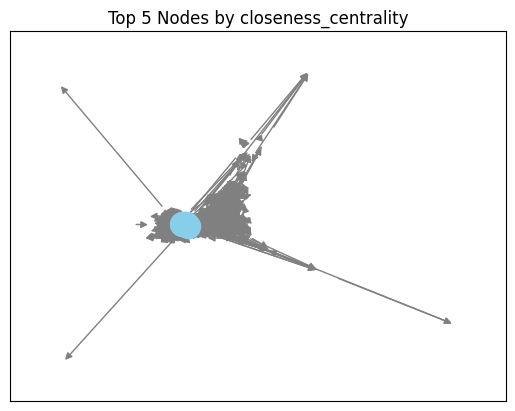

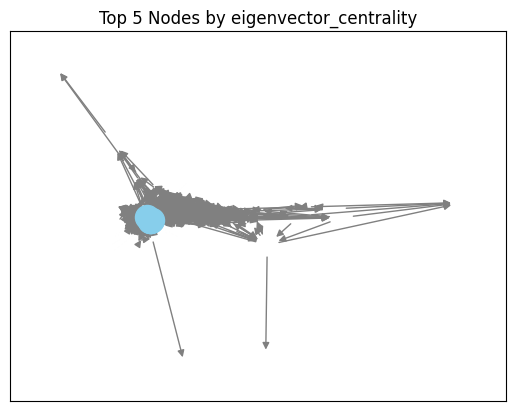

In [15]:
def visualize_top_nodes(graph, centrality_measure, top_n=5):
    centrality_values = centrality_measure(graph)
    sorted_centrality = sorted(centrality_values.items(), key=lambda x: x[1], reverse=True)
    top_nodes = dict(sorted_centrality[:top_n])

    pos = nx.spring_layout(graph)
    node_labels = {node: f"{node}\nCentrality: {centrality:.4f}" for node, centrality in top_nodes.items()}

    nx.draw_networkx_nodes(graph, pos, nodelist=top_nodes.keys(), node_size=300, node_color='skyblue')
    #nx.draw_networkx_labels(graph, pos, labels=node_labels, font_size=8)
    nx.draw_networkx_edges(graph, pos, edge_color='gray', arrowsize=10)

    plt.title(f'Top {top_n} Nodes by {centrality_measure.__name__}')
    plt.show()

# Visualize the top 5 nodes for each centrality measure
visualize_top_nodes(G, nx.degree_centrality, top_n=5)
visualize_top_nodes(G, nx.betweenness_centrality, top_n=5)
visualize_top_nodes(G, nx.closeness_centrality, top_n=5)
visualize_top_nodes(G, nx.eigenvector_centrality, top_n=5)


### Community Detection

This is a technique used in network analysis to identify groups of nodes that are more densely connected internally than with the rest of the network. Two popular methods for community detection are Modularity-based Methods and the Louvain Method. The Girvan-Newman Algorithm is often used for hierarchical community detection.

Modularity-based Methods based method is a that quantifies the quality of a partition of a network into communities. It compares the actual number of edges within communities to the expected number of edges in a random network. Optimal community structure is achieved by maximizing the modularity function. Higher modularity values indicate better community structures.

Louvain Method is a greedy optimization algorithm that aims to maximize modularity. It iteratively optimizes the modularity by moving nodes between communities to find the best partition. It identifies a community structure that maximizes internal connectivity and minimizes external connectivity.

Girvan-Newman Algorithm is based on the idea of edge betweenness. It identifies edges that, when removed, lead to the greatest increase in network connectivity. The algorithm iteratively removes edges with the highest betweenness until the community structure is revealed. The resulting dendrogram can be cut at different levels to identify communities at different scales.

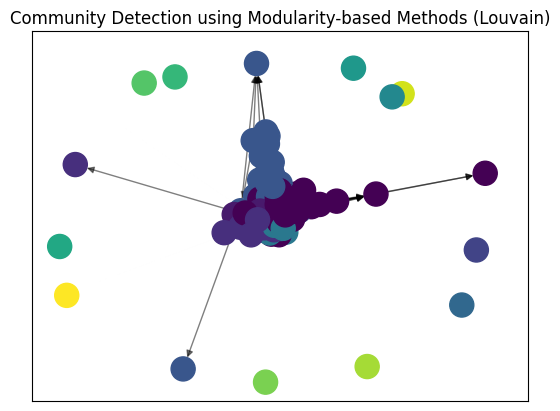

Node 13001 belongs to Community 0
Node KA1504000117 belongs to Community 1
Node 17660 belongs to Community 1
Node 13432 belongs to Community 1
Node SL-012 belongs to Community 0
Node KA1503000044 belongs to Community 1
Node 13196 belongs to Community 1
Node 13197 belongs to Community 1
Node 15655 belongs to Community 1
Node 13128 belongs to Community 1
Node 13303 belongs to Community 1
Node TA1307000107 belongs to Community 2
Node TA1309000030 belongs to Community 1
Node KA1504000152 belongs to Community 2
Node KA1504000097 belongs to Community 2
Node KA1504000147 belongs to Community 2
Node 13276 belongs to Community 2
Node KA1504000143 belongs to Community 2
Node 13249 belongs to Community 2
Node KA1504000134 belongs to Community 1
Node TA1309000019 belongs to Community 1
Node TA1307000142 belongs to Community 2
Node TA1306000016 belongs to Community 1
Node SL-005 belongs to Community 0
Node SL-010 belongs to Community 0
Node 623 belongs to Community 0
Node 13022 belongs to Community

In [16]:
# Convert the graph to an undirected graph for community detection
G_undirected = G.to_undirected()

# Apply the Louvain method to detect communities
# partition = community.best_partition(G_undirected)
comms = community_louvain.best_partition(G_undirected)

# Visualize the communities
pos = nx.spring_layout(G)
cmap = plt.get_cmap('viridis')

nx.draw_networkx_nodes(G, pos, node_size=300, cmap=cmap, node_color=list(comms.values()))
nx.draw_networkx_edges(G, pos, alpha=0.5)
plt.title('Community Detection using Modularity-based Methods (Louvain)')
plt.show()

# Print community assignments for each node
for node, community_id in comms.items():
    print(f"Node {node} belongs to Community {community_id}")

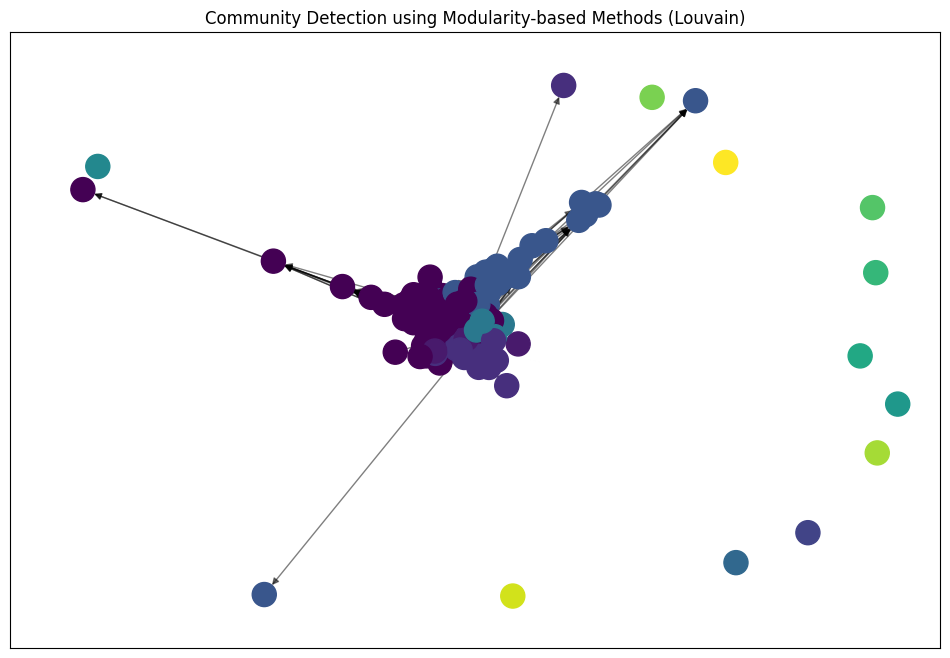

In [17]:
pos = nx.spring_layout(G)
cmap = plt.get_cmap('viridis')
plt.figure(figsize=(12, 8))
nx.draw_networkx_nodes(G, pos, node_size=300, cmap=cmap, node_color=list(comms.values()))
nx.draw_networkx_edges(G, pos, alpha=0.5)
plt.title('Community Detection using Modularity-based Methods (Louvain)')
plt.show()

### PageRank Algorithm
Application for Ranking Nodes

PageRank algorithm assigns a numerical weight to each node in a network graph. The purpose of PageRank is to measure the importance of a node based on its connections and the importance of nodes connected to it.

Nodes with higher PageRank values are considered more important or central in the network. It implies that the node has more influential connections or is connected to other important nodes.

Nodes with lower PageRank values are considered less important or central. They might have fewer or less influential connections.

Here are the top 10 and lower 10 nodes based on their PageRank values.

In [18]:
pr = nx.pagerank(G)

# Sort nodes by PageRank values in descending order
sorted_pr = sorted(pr.items(), key=lambda x: x[1], reverse=True)

# Print the top 5 nodes
print("\nTop 5 nodes by PageRank:")
for node, pagerank in sorted_pr[:5]:
    print(f"Node {node}: {pagerank}")

# Print the lower 5 nodes
print("\nLower 5 nodes by PageRank:")
for node, pagerank in sorted_pr[-5:]:
    print(f"Node {node}: {pagerank}")


Top 5 nodes by PageRank:
Node 13022: 0.0038187211973840385
Node 13042: 0.0035751768954506917
Node 13300: 0.0035332690559927694
Node LF-005: 0.0035259360992790797
Node 13008: 0.0033863664312141404

Lower 5 nodes by PageRank:
Node 20129: 0.00021597210739974804
Node 473: 0.00021597210739974804
Node 354: 0.00021597210739974804
Node 330.0: 0.00021597210739974804
Node 20217: 0.00021597210739974804


### Link Prediction
Common Neighbors

Link prediction is a technique used in network analysis to predict the likelihood of a connection (link) between two nodes in a graph. One common approach for link prediction is based on common neighbors. The idea is that nodes that share common neighbors are more likely to form a link in the future.

In [19]:
# Create a copy of the graph to work with
G_copy = G.copy()

# Identify potential links (missing edges) for prediction
missing_edges = list(combinations(G_copy.nodes(), 2))

# Remove existing edges from the list of potential links
missing_edges = [edge for edge in missing_edges if not G_copy.has_edge(*edge)]

# Calculate common neighbors for each potential link
common_neighbors_predictions = []
for edge in missing_edges:
    common_neighbors = len(set(G_copy.neighbors(edge[0])) & set(G_copy.neighbors(edge[1])))
    common_neighbors_predictions.append((edge, common_neighbors))

# Sort predictions by common neighbors in descending order
sorted_predictions = sorted(common_neighbors_predictions, key=lambda x: x[1], reverse=True)

# Print the top 5 link predictions based on common neighbors
print("\nTop 5 Link Predictions based on Common Neighbors:")
for prediction in sorted_predictions[:5]:
    print(f"Nodes {prediction[0]} with Common Neighbors: {prediction[1]}")



Top 5 Link Predictions based on Common Neighbors:
Nodes ('TA1306000015', '13300') with Common Neighbors: 227
Nodes ('TA1309000019', '13033') with Common Neighbors: 218
Nodes ('TA1305000041', '13191') with Common Neighbors: 218
Nodes ('13008', 'TA1309000058') with Common Neighbors: 216
Nodes ('TA1307000142', 'TA1307000120') with Common Neighbors: 215


### Routing Algorithms
Shortest Path Algorithms are used in network analysis to find the most efficient path or route between two nodes in a graph.

Dijkstra's algorithm is used to find the shortest path between a source node and all other nodes in a weighted graph.
It works well for graphs with non-negative weights on edges.
The algorithm maintains a set of visited nodes and calculates the shortest distance from the source node to each other node.
It iteratively selects the node with the smallest tentative distance, adds it to the visited set, and updates the distances of its neighbors.

In [20]:
# Assuming source' is the source node
source_node = '13001'

# Calculate the shortest path lengths from the source node to all other nodes
shortest_path_lengths = nx.single_source_dijkstra_path_length(G, source=source_node)

# Get the top 10 nodes based on shortest path lengths
top_5_nodes = sorted(shortest_path_lengths.items(), key=lambda x: x[1])[:5]

# Print the result
print("Top 5 nodes and their shortest path lengths:")
for node, length in top_5_nodes:
    print(f"Node {node}: Shortest Path Length = {length}")


Top 5 nodes and their shortest path lengths:
Node 13001: Shortest Path Length = 0
Node 13006: Shortest Path Length = 1
Node 13008: Shortest Path Length = 1
Node 13011: Shortest Path Length = 1
Node 13016: Shortest Path Length = 1


Overall Topology of Bike-sharing Network:

The bike-sharing network exhibits a diverse topology with stations interconnected through rides.
Stations like 13022, 13300, and 13008 have high centrality, indicating they are well-connected hubs.

Patterns in User Behavior:

Degree Centrality identifies stations like LF-005 as crucial points, potentially serving as popular destinations.
Betweenness Centrality highlights stations like 13008 and TA1308000009, suggesting they play a key role in connecting different parts of the network.
Closeness Centrality showcases stations like 13022 and 13300 as central locations, emphasizing their accessibility.

Common Starting and Ending Points for User Groups:

Eigenvector Centrality identifies stations like 13022, 13042, and LF-005 as significant in terms of user influence.
Stations with high Eigenvector Centrality may represent popular starting or ending points for different user groups.

In summary, the provided centrality measures offer valuable insights into the network's structure and user behaviors, but additional temporal and user-specific analyses would provide more detailed answers to some of the questions.


Reference: https://www.kaggle.com/datasets/lakshmi25npathi/bike-sharing-dataset